In [29]:
# Install necessary libraries
!pip install sentence-transformers scikit-learn matplotlib kneed umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
import pandas as pd

# Read the CSV file into a DataFrame
events_df = pd.read_csv('monday.csv')

# List the columns of the DataFrame
columns = events_df.columns.tolist()
print("Columns in the DataFrame:", columns)

Columns in the DataFrame: ['Name', 'Time', 'Location', 'Link', 'Host']


loading model...


/opt/homebrew/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


creating embeddings...
                                                     all week discover nyc ai walking tour self guided  \
 all week discover nyc ai walking tour self guided                                           0.000000    
web3 latoken breakfast                                                                     872.065835    
nytw kickoff breakfast optimize your techweek s...                                         648.957789    
genai monday breakfast with pinecone                                                       880.723062    
vc barry s breakfast                                                                       811.266898    
...                                                                                               ...    
f7 founders friends dinner                                                                 758.623310    
nytw snark tank comedy monday tech pitch roast ...                                         704.193393    
nba conference finals g

/opt/homebrew/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


determining optimal number of clusters using elbow method
Optimal number of clusters: 3


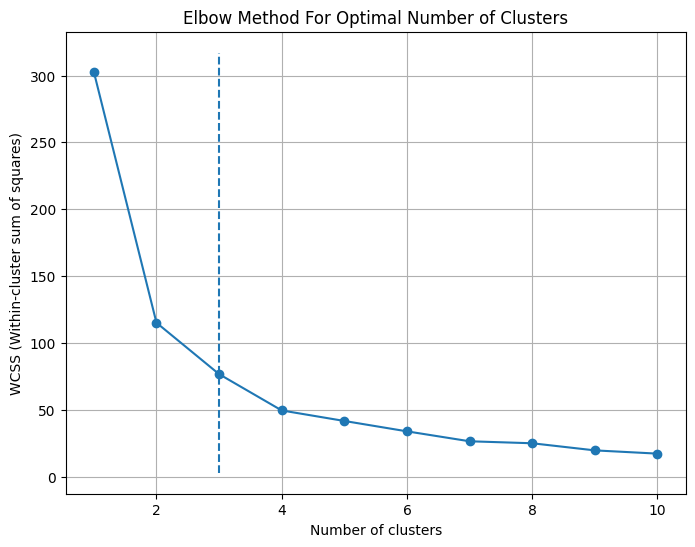

performing KMeans clustering with 3 clusters


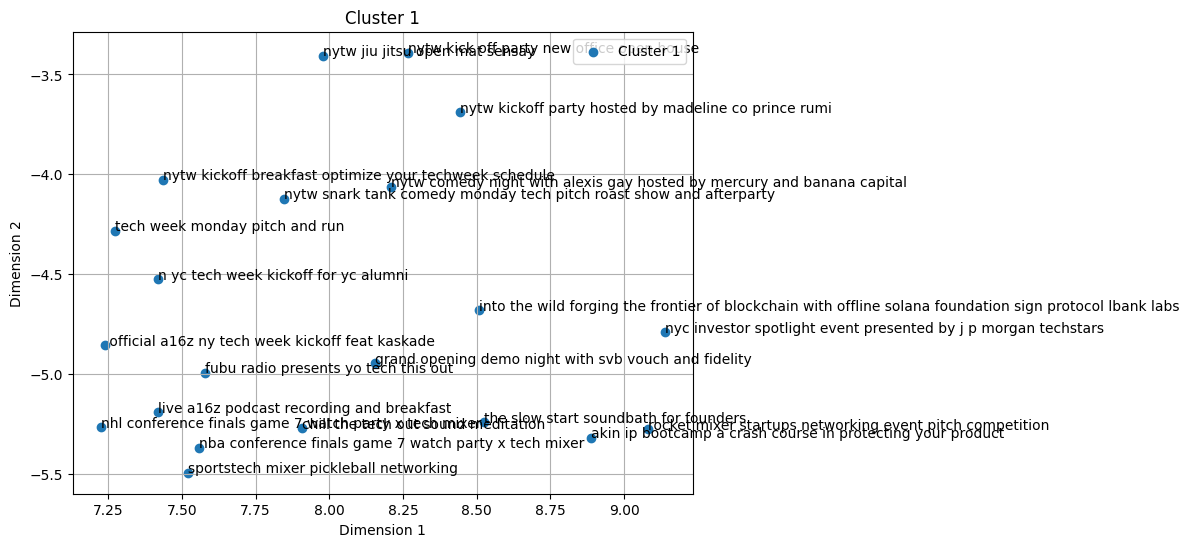

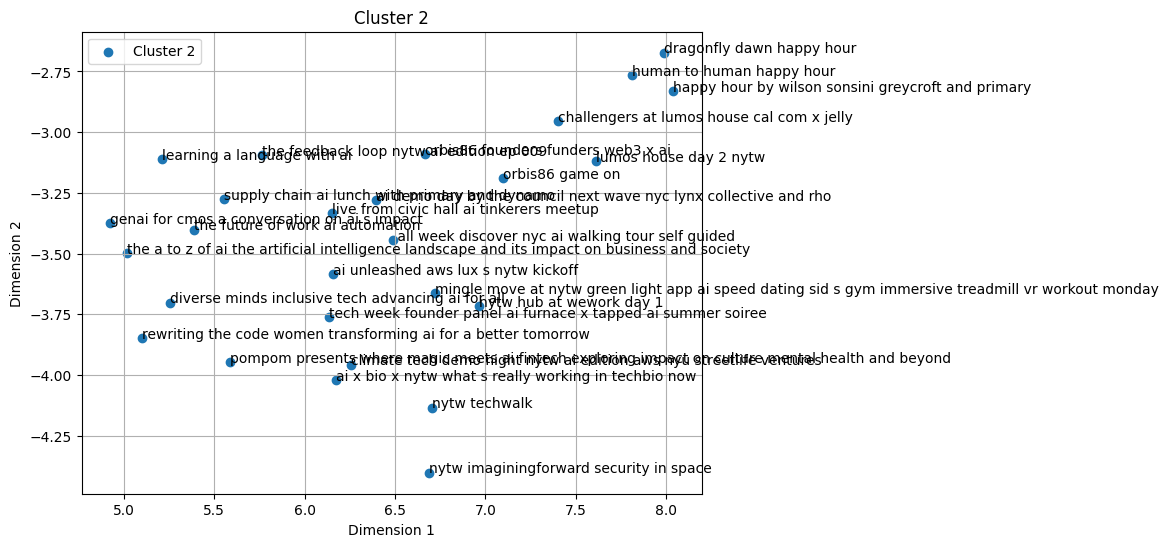

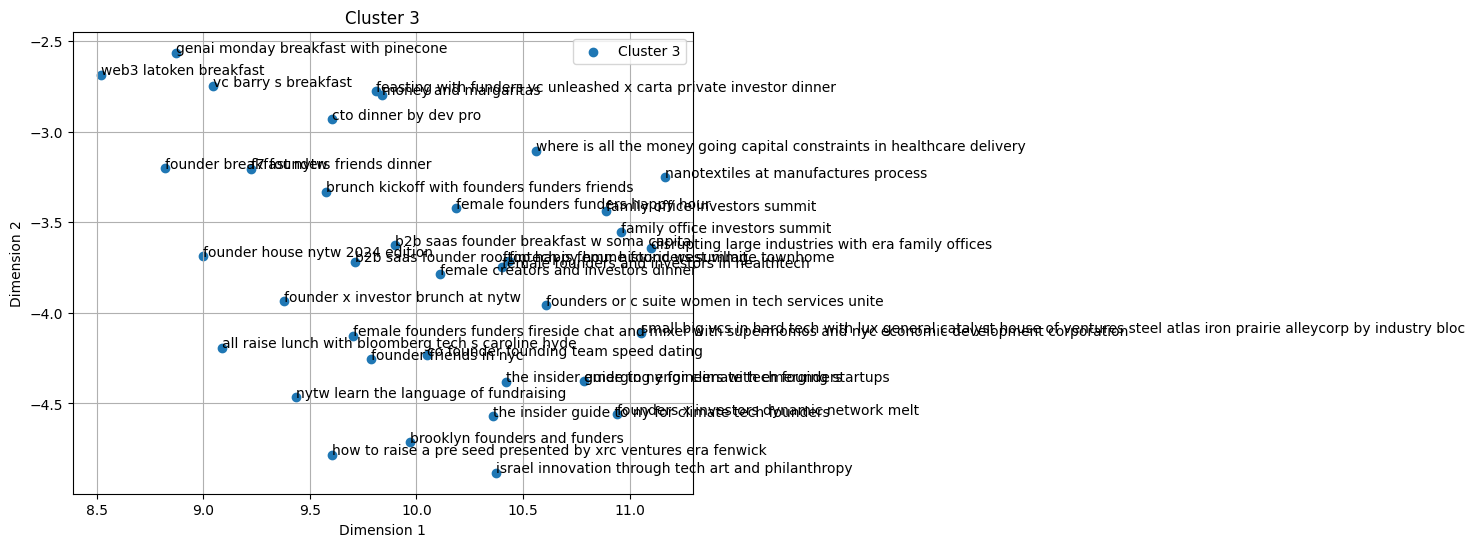

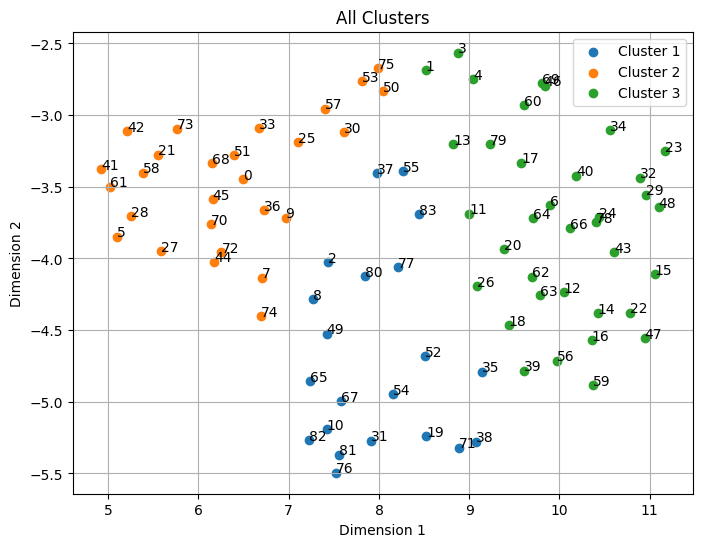

In [32]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import pairwise_distances
import umap.umap_ as umap  # Correct import for UMAP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import normalize
import re

# Load the CSV file into a DataFrame
events_df = pd.read_csv('monday.csv')

# Preprocess the "Name" column
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

events_df['Name'] = events_df['Name'].apply(preprocess_text)
sentences = events_df['Name'].to_numpy()

print("loading model...")
# Load the sentence transformer model
model = SentenceTransformer('all-mpnet-base-v2')

print("creating embeddings...")
# Create embeddings for sentences
embeddings = model.encode(sentences)

# Normalize embeddings
embeddings = normalize(embeddings)

# Calculate pairwise Cosine distances
distances = pairwise_distances(embeddings, metric='manhattan')

# Convert to R² distances
r2_distances = np.square(distances)

# Convert distances to a DataFrame for easier viewing
df = pd.DataFrame(r2_distances, index=sentences, columns=sentences)
print(df)

print("visualizing with MDS...")
# Visualize the distances using MDS (Multidimensional Scaling)
# Visualize the distances using UMAP
umap_model = umap.UMAP(n_components=2, metric='manhattan', random_state=42)
mds_coords = umap_model.fit_transform(embeddings)

# Determine the optimal number of clusters using the elbow method
print("determining optimal number of clusters using elbow method")
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(mds_coords)
    wcss.append(kmeans.inertia_)

# Find the elbow point using KneeLocator
kneedle = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow

print(f"Optimal number of clusters: {optimal_clusters}")

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.vlines(optimal_clusters, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

# Perform clustering using KMeans with the optimal number of clusters
print(f"performing KMeans clustering with {optimal_clusters} clusters")
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(mds_coords)

# Plot each cluster separately
for cluster in range(optimal_clusters):
    plt.figure(figsize=(8, 6))
    cluster_points = mds_coords[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster+1}')
    
    for i, sentence in enumerate(sentences[labels == cluster]):
        plt.annotate(sentence, (cluster_points[i, 0], cluster_points[i, 1]))

    plt.title(f'Cluster {cluster+1}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'cluster_{cluster+1}.png')
    plt.show()

# Optionally, plot all clusters together for comparison
plt.figure(figsize=(8, 6))
for cluster in range(optimal_clusters):
    cluster_points = mds_coords[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster+1}')

for i, sentence in enumerate(sentences):
    plt.annotate(i, (mds_coords[i, 0], mds_coords[i, 1]))

plt.title('All Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.savefig('all_clusters.png')
plt.show()
